In [3]:
from datetime import datetime
import pandas as pd

# import jsonlines
# import gcsfs
# fs = gcsfs.GCSFileSystem(project='sm4h-rxspace')
# now = datetime.now()
# dt = now.strftime('%Y-%m-%d %H:%M')
# print(f'start time:\n{dt}')
# # pip instlal requirements
# !pip install pandas==0.25.0;
# !pip install tqdm==4.33.0;

# !pip install snorkel;
# !pip install spacy;
# !python -m spacy download en_core_web_md;
# !pip install spacy-lookup;
# !pip install lemminflect;
# !pip install pandas-profiling;

In [4]:
# importing functions and etc
import spacy
from spacy.tokens import Doc, Span, Token
from spacy_lookup import Entity
from lemminflect import getAllInflectionsOOV
from spacy.matcher import Matcher
import en_core_web_md
import re
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis, LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.preprocess import preprocessor
from snorkel.preprocess.nlp import SpacyPreprocessor
from snorkel.labeling.lf.nlp import nlp_labeling_function
import io
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn


In [5]:
train_path = "train.csv"
dev_path ="validation.csv"
#dev_path = "gs://sm4h-rxspace/task4/validation.csv"
print(f'train path : {train_path}\ndev path : {dev_path}')

train path : train.csv
dev path : validation.csv


In [6]:
def get_distribution(df, col='class'):
    """gives distribution of a column """
    df_out = df[col].value_counts()
    n_train = df.shape[0]
    print(f"loaded {n_train} samples\n")

    df_out = pd.DataFrame(df_out)
    df_out.columns = ['class counts']
    df_out['class %'] = round(100 * df_out['class counts'] / n_train, 2)
    return df_out

df_raw = pd.read_csv(train_path)
df_raw['class'] = df_raw['class'].map(str.strip) # some labels have a trailing space
df_train = df_raw[['unprocessed_text']].rename(columns={'unprocessed_text':'text'})
df_labels = df_raw[['class']]

print(f'loading train from {train_path}..')

print(get_distribution(df_raw))

loading train from train.csv..
loaded 10537 samples

   class counts  class %
m  5488          52.08  
c  2940          27.90  
a  1685          15.99  
u  424           4.02   


In [9]:
df_val_raw = pd.read_csv(dev_path)
df_val_raw['class'] = df_val_raw['class'].map(str.strip)

df_val = df_val_raw.rename(columns={'unprocessed_text':'text'})
df_val_labels = df_val_raw[['class']]
print(f'loading dev from {dev_path}..')
print(get_distribution(df_val_raw))

loading dev from validation.csv..
loaded 2635 samples

   class counts  class %
m  1353          51.35  
c  730           27.70  
a  448           17.00  
u  104           3.95   


In [10]:
# loading bseline spacy model
nlp = en_core_web_md.load()

ABSTAIN = -1
ABUSE = 0
MENTION = 1
CONSUMPTION = 2
UNRELATED = 3

In [11]:
# TODO : add Whitley and Mark's drug list into the drugs dictionary
# drugname, is_slang, is_commonly_abused
drugs = {
    'alprazolam' : {
        'is_commonly_abused' : True,
        'slang_terms' : [
            'xanny', 'xannies'],
        'normal_terms' : [
            'xanax', 'xan', 'xanex', 'niravam'],
    },
    'codeine' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'codeine', 'codiene', 'cocet'],
    },
    'adderall' : {
        'is_commonly_abused' : True,
        'slang_terms' : [
            'addy', 'addies', 'addys'],
        'normal_terms' : [
            'adderall', 'aderall', 'adarall', 'addarall', 'adoral'],
    },
    'valium' : {
        'is_commonly_abused' : False,
        'slang_terms' : [],
        'normal_terms' : [
            'valium', 'vallium'],
    },
    'vyvanse' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'vyvanse'],
    },
    'fentanyl' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'fentanyl', 'fentynyl', 'fentenyl', 'fentanil', 'abstral', 
            'actiq', 'fentora', 'onsolis', 'sublimaze', 'duragesic'],
    },
    'oxycodone' : {
        'is_commonly_abused' : True,
        'slang_terms' : ['oxy'],
        'normal_terms' : [
            'oxycodone', 'oxaydo', 'xtampza', 'oxycontin', 'oxycotin', 'oxycodin'],
    },
    'hydrocodone' : {
        'is_commonly_abused' : True,
        'slang_terms' : [],
        'normal_terms' : [
            'hydrocodone', 'hysingla', 'zohydro', 'vicodin', 'hycet',
            'lorcet', 'lortab', 'norco', 'verdrocet', 'xodol'],
    },
    'methadone' : {
        'is_commonly_abused' : False,
        'slang_terms' : [],
        'normal_terms' : [
            'methadone', 'dolophine', 'methadose'],
    },
    'morphine' : {'is_commonly_abused' : True,
                  'slang_terms' : [],
                  'normal_terms' : ['morphine', 'avinza', 'oramorph', 'roxanol', 'rms'],
                },
    'diazepam' : {'is_commonly_abused' : True,
                  'slang_terms' : [],
                  'normal_terms' : ['diazepam', 'valium'],
            },
    'tramadol' : {'is_commonly_abused' : False,
                  'slang_terms' : [],
                  'normal_terms' : ['tramadol', 'ultram'],
            },
    'quetiapine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['quetiapine', 'seroquel'],
            },
    'lorazepam' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['lorazepam', 'ativan'],
            },
    'clonazepam' : {'is_commonly_abused' : True,
                    'slang_terms' : [],
                    'normal_terms' : ['clonazepam', 'klonopin'],
            },
    'percocet' : {'is_commonly_abused' : True,
                  'slang_terms' : ['percs', 'perc'],
                  'normal_terms' : ['percocet', 'percacet', 'percicet'],
            },
    'aripiprazole' : {'is_commonly_abused' : False,
                      'slang_terms' : [],
                      'normal_terms' : ['aripiprazole', 'abilify'],
            },
    'buprenorphine' : {'is_commonly_abused' : False,
                       'slang_terms' : [],
                       'normal_terms' : ['buprenorphine', 'suboxone', 'naloxone', 'bunavail', 'zubsolv'],
            },
    'olanzapine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['olanzapine', 'zyprexa', 'zydis'],
            },
    'methylphenidate' : {'is_commonly_abused' : True,
                         'slang_terms' : [],
                         'normal_terms' : ['methylphenidate', 'aptensio', 'concerta', 'cotempla', 'metadate',
                                           'methylin',  'quillichew', 'quillivant', 'ritalin'],
            },
    'risperidone' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['risperidone ', 'risperdal'],
            },
    'caffeine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['caffeine', 'caffiene', 'coffee'],
            },
    'amphetamine' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['amphetamine', 'adzenys', 'dyanavel'],
            },
    'hydromorphone' : {'is_commonly_abused' : False,
                    'slang_terms' : [],
                    'normal_terms' : ['hydromorphone', 'dilaudid', 'exalgo', 'hydrostat'],
            },
}


verbs_slang = {'snort', 'crush', 'inject', 'pop', 'rail', 'sniff', 'trip', 'chug'
               'spill', 'binge', 'sling', 'slang', 'snortin'}



# generate dict that maps terms to keys and values includ parent term, is_slang, is_commonly_abused
drug_term_LUT = {}

for parent_term, subdict in drugs.items():
    for slang_term in subdict['slang_terms']:
        drug_term_LUT[slang_term] = {
        'parent_term' : parent_term,
        'is_slang' : True,
        'is_commonly_abused' : subdict['is_commonly_abused']
    }
        
    for normal_term in subdict['normal_terms']:
        drug_term_LUT[normal_term] = {
        'parent_term' : parent_term,
        'is_slang' : False,
        'is_commonly_abused' : subdict['is_commonly_abused']
    }

# creating pipes
drug_entity_pipe = Entity(keywords_list=list(drug_term_LUT.keys()), label='DRUG')
nlp.add_pipe(drug_entity_pipe, before='ner')

has_drug_term = lambda doc : any([True for ent in doc.ents if ent.label_ == 'DRUG'])
has_slang_drug_term = lambda doc : any([ent._.get('is_slang') for ent in doc.ents if ent.label_ == 'DRUG'])
has_commonly_abused_drug_term = lambda doc : any([ent._.get('is_commonly_abused') for ent in doc.ents if ent.label_ == 'DRUG'])


@preprocessor(memoize=True)
def nlpify(x):
    # preprocessor gets the series obj, so extract string
    doc = nlp(x['text'])
    Span.set_extension('is_commonly_abused', default=False, force=True)
    Span.set_extension('is_slang', default=False, force=True)
    for ent in doc.ents:
        if ent.label_ == 'DRUG':
            ent._.set('is_commonly_abused', drug_term_LUT[ent.text.lower()]['is_commonly_abused'])
            ent._.set('is_slang', drug_term_LUT[ent.text.lower()]['is_slang'])
            # for token in ent:
            #   token._.set('is_commonly_abused', drug_term_LUT[ent.text]['is_commonly_abused'])
            #   token._.set('is_slang', drug_term_LUT[ent.text]['is_slang'])
    Doc.set_extension('has_drug_term', getter=has_drug_term, force=True)
    Doc.set_extension('has_commonly_abused_drug_term', getter=has_commonly_abused_drug_term, force=True)
    Doc.set_extension('has_slang_drug_term', getter=has_slang_drug_term, force=True)
    return doc


In [12]:
# labeling fxns
@labeling_function(pre=[nlpify])
def drug_with_slang_usage(doc):
    '''check if drug name in text and mention of abusive use'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB' and head.lemma_ in verbs_slang:
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def no_drugnames_found(doc):
    '''Check if no drugnames were found'''
    if not doc._.has_drug_term:
        return UNRELATED
    return ABSTAIN


@labeling_function(pre=[nlpify])
def slang_drug_with_usage(doc):
    '''check if a commonly abused drugname and there's a verb associated with it'''
    if doc._.has_slang_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG' and ent._.is_slang:
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB':
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def normal_drug_with_usage(doc):
    '''check if a normal drugname and there's a non-slang verb associated with it'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG' and not ent._.is_slang:
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB' and head.lemma_ not in verbs_slang:
                    return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def slang_side_effects(doc):
    '''Drug mentioned and slang mention of a side effect'''
    effect_regexes = [
        'fuck(ed)? (me )?up',
        'fuck(ed)? with'
        'lit(ty)?',
        'high',
        'od', 'oveerdose(d)?',
        'addict(ed|ing)?',
        'hooked',
        'habit',
        'mellow',
        'doped',
        'hallucinat(e)?(d|ing)?',
        'trip(ping)?',
        'rollin(g)?',
        'buzz(ed)?',
        'black(ed)? out',
        'no memory',
        'burning'
        ]
    if doc._.has_drug_term and re.search('|'.join(effect_regexes), doc.text.lower()):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_with_no_usage(doc):
    '''Drug mentioned but not in the context of being used'''
    if doc._.has_drug_term:
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                head = [t for t in ent][0].head  # get head of the drug entity
                if head.pos_ == 'VERB':
                    return ABSTAIN
    return MENTION


@labeling_function(pre=[nlpify])
def clinical_terms(doc):
    '''Drug mentioned but with cclinical terms around it'''
    medical_terms = {
        'doctor', 'nurse'  # TODO : add more medicl terms that indicate typical usage
        }
    medical_regex = r'(doctor|nurse|(re(- )?)?admi(t|ssion)(s)?|hospital)'
    if doc._.has_drug_term and medical_terms.intersection(set([t for t in doc])):
        return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def abusive_activities(doc):
    ''' drug usage mentioned for the purposes of unintended use '''
    activities = {
        'adderall': ['clean', 'study'],
        'vyvanse': ['study']
        }
    if doc._.has_drug_term:
        for ent in [ent for ent in doc.ents if ent.label_ == 'DRUG']:
            drug = drug_term_LUT.get(ent.text.lower())
            if drug:
                drug_activities = activities.get(drug['parent_term'])
                if drug_activities:
                    for token in doc:
                        if token.lemma_ in drug_activities:
                            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def study_aid(doc):
    ''' drugs being useed speccifically as study aid '''
    if doc._.has_drug_term:
        study_aid_drugs = {'adderall', 'vyvanse'}
        drugs = set([drug_term_LUT.get(ent.label_.lower()) for ent in doc.ents if ent.label_ == 'DRUG'])
        if drugs.intersection(study_aid_drugs):
            study_regex = r'(wak(e|ing)|study(ing)?|homework|school(s)?|libar(y|ies)|education|class(es)?|semester(' \
                          r's)?|exam(s)?|paper(s)?|campus|essay(s)?|college|uni(versity)?)'
            if re.search(study_regex, doc.text.lower()):
                return abuse
    return ABSTAIN


@labeling_function(pre=[nlpify])
def soliciting_drug(doc):
    '''Check if there is a regex pattern indicating the persom asking for drug'''
    if doc._.has_drug_term:
        regex = "(any ?one|someone|any ?body|who|y'all|I|gonna).*(" \
                "steal|stole|get|got|has|had|have|holding|find|found|need(ed)?|want|share).*"
        if re.search(regex, doc.text.lower()):
            return ABUSE
        other_soliciting_terms = {'hmu', }
        if other_soliciting_terms.intersection(set([token.text.lower() for token in doc])):
            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def suspicious_emojis(doc):
    '''drug mentioned and has emojis commonly used when mentioning abuse'''
    suspicious_emojis = {'💊', '🍁', '🍀', '🌴', '🌳', '🌲', '💨'
                                                             '❄', '⛄', '🔑', '🌨', '🍚', '🤧', '🎱',
                         '💉', '🎯', '🐉', '🍄', }  # TODO add more suspicious emojis
    if doc._.has_drug_term and suspicious_emojis.intersection(set([t for t in doc])):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def expected_usage(doc):
    '''check for each drug mentioned whether theres a mention of a term commonly associated with expected usage'''
    usage = {
        'seroquel': {'sleep', 'insomnia'},  # TODO : add more common drug usage matches
        'xanax': {'anxiety', 'anxious'},
        'valium': {'axiety', 'anxious'},
        
        }
    if doc._.has_drug_term:
        token_set = set([t for t in doc])
        for ent in doc.ents:
            if ent.label_ == 'DRUG':
                if usage.get(ent.text.lower(), set()).intersection(token_set):
                    return CONSUMPTION
    return ABSTAIN



@labeling_function(pre=[nlpify])
def lyrica_as_nondrug(doc):
    if 'lyrica' in doc.text.lower() and re.search('(anderson|lhhh|song|ginny|breisha|lgbt(q)?)', doc.text.lower()):
        return UNRELATED

    with nlp.disable_pipes('entity'):
        w_doc = nlp(doc.text)
        lyrica_person = False
        for ent in w_doc.ents:
            if 'lyrica' in ent.text.lower() and ent.label_ == 'PERSON':
                lyrica_person = True
        if lyrica_person:
            found_other_drug_term = False
            for ent in doc.ents:
                if 'lyrica' not in ent.text.lower() and ent.label_ == 'DRUG':
                    found_other_drug_term = True
            if not found_other_drug_term:
                return UNRELATED

    textlist = doc.text.replace('_U', '').lower().split()
    if 'lyrica' in textlist:
        if len(textlist) < 5:
            return UNRELATED
        else:
            for ent in doc.ents:
                if 'lyrica' in ent.text.lower() and ent.label_ != 'DRUG':
                    return UNRELATED
    return ABSTAIN


@labeling_function(pre=[nlpify])
def buy_or_sell(doc):
    if doc._.has_drug_term:
        lemmas = set([token.lemma_ for token in doc])
        if 'buy' or 'sell' in lemmas:
            return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def short_tweet(doc):
    if doc._.has_drug_term and len(doc.text.split()) <= 5:
        return MENTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def chill_pill(doc):
    '''someone tells another person to take some drug to calm down'''
    if doc._.has_drug_term:
        found_drugs = set([ent.text.lower() for ent in doc.ents if ent.label_ == 'DRUG'])
        if found_drugs:
            chill_regex = "take (a|some)[a-z _-]{0,10}(" + '|'.join(found_drugs) + ')'
            if re.search(chill_regex, doc.text.lower()):
                return MENTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drugs_for_sleep(doc):
    ''' mentions of drugs used to help sleep '''
    if doc._.has_drug_term and re.search(r"(sleep(ing)?|(good[ ]?)?night)", doc.text.lower()):
        return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_feels_like(doc):
    '''someone mentioning one drug is like something else : ampetemine is like adderall'''
    if doc._.has_drug_term and re.search(r"(is|it(\')?s)[ ,a-z0-9]{,8}(like|similar)", doc.text.lower()):
        return MENTION
    return ABSTAIN






In [13]:
## TODO RULES

# anything + alchcohol
# anyhtin + energy drink

# check for drugs that are mentioned in the hashtag, e.g. #aderrall (not captured by nlp?)

@labeling_function(pre=[nlpify])
def mixing_drugs(doc):
    '''mention of mixing drugs often used in abuse'''
    # map to all alias terms
    abuse_pairs = [
        ('ambien', 'percocet'),
        ('adderall', 'alcohol'),
        ('adderall', 'coffee'),
        ]
    if doc._.has_drug_term:
        pdrugs = [drug_term_LUT.get(ent.text.lower(), {}).get('parent_term') for ent in doc.ents if
                  ent.label_ == 'DRUG']
        drugset = set([drug for drug in pdrugs if drug])
        if len(drugset) >= 2:
            drug_pairs = itertools.combinations(drugset, 2)
            for pair in drug_pairs:
                if pair in abuse_pairs:
                    return ABUSE
    return ABSTAIN


@labeling_function(pre=[nlpify])
def person_on_rx(doc):
    ''' mention where person indicates the drug is and rx'''
    if doc._.has_drug_term and not doc._.has_slang_drug_term:
        if re.search('(got|have)[ ]+(me|him|her|my) (on|taking|using)', doc.text.lower()):
            return CONSUMPTION
    return ABSTAIN


@labeling_function(pre=[nlpify])
def drug_had_me(doc):
    ''' adderall had me ..., indicating side effect of normal use'''
    if doc._.has_drug_term:
        for ent in [ent for ent in doc.ents if ent.label_ == 'DRUG']:
            if drug_term_LUT.get(ent.text, {}).get('parent_term') in {'adderall', 'vyvanse'}:
                idx = doc.text.index(ent.text)
                if re.search('^[ ]*(have|has|had|got) (me|her|him|them)', doc.text.lower()[idx + len(ent.text):]):
                    return CONSUMPTION
    return ABSTAIN



In [14]:
# symptooms of /feelings regarding abuse


In [15]:
lfs = [drug_with_slang_usage,
       no_drugnames_found,
       slang_drug_with_usage,
       normal_drug_with_usage,
       slang_side_effects,
       drug_with_no_usage,
       clinical_terms,
       abusive_activities,
       study_aid,
       soliciting_drug,
       suspicious_emojis,
       expected_usage,
       lyrica_as_nondrug,
       buy_or_sell,
       short_tweet,
       chill_pill,
       drugs_for_sleep,
       drug_feels_like,
       mixing_drugs,
       person_on_rx,
       drug_had_me
       ]

# appling with pandas LF applier
applier = PandasLFApplier(lfs)
# applying to datasets

L_train = applier.apply(df_train, progress_bar=True)

L_val = applier.apply(df_val, progress_bar=True)

class2label = {'a': 0, 'm': 1, 'c': 2, 'u': 3}
Y = df_labels['class'].map(lambda x: class2label[x]).to_numpy()

Y_val = df_val_labels['class'].map(lambda x: class2label[x]).to_numpy()

/Users/user/miniconda3/envs/main/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 10537/10537 [11:58<00:00, 14.67it/s]
/Users/user/miniconda3/envs/main/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 2635/2635 [02:45<00:00, 15.91it/s]


In [16]:

## summary anlysis 
summary_analysis = LFAnalysis(L_train, lfs).lf_summary(Y)
summary_analysis

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
drug_with_slang_usage,0,[0],0.016893,0.016893,0.000949,76,102,0.426966
no_drugnames_found,1,[3],0.074689,0.074689,0.074689,329,458,0.418043
slang_drug_with_usage,2,[0],0.002278,0.002278,0.000475,4,20,0.166667
normal_drug_with_usage,3,[2],0.454589,0.454589,0.454589,1581,3209,0.330063
slang_side_effects,4,[0],0.226250,0.226250,0.222549,442,1942,0.185403
drug_with_no_usage,5,[1],0.527285,0.527285,0.527285,3003,2553,0.540497
clinical_terms,6,[],0.000000,0.000000,0.000000,0,0,0.000000
abusive_activities,7,[0],0.007497,0.007497,0.007308,45,34,0.569620
study_aid,8,[],0.000000,0.000000,0.000000,0,0,0.000000
soliciting_drug,9,[0],0.029515,0.029515,0.029230,94,217,0.302251


In [17]:
label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)  # , class_balance=[.15, .5, .3, .05]);
df_train["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")
df_val["label"] = label_model.predict(L=L_val, tie_break_policy="abstain")
# looking at weights
weights = summary_analysis[['j']]
weights['w'] = [round(w, 3) for w in label_model.get_weights()]
weights

/Users/user/miniconda3/envs/main/lib/python3.7/site-packages/snorkel/labeling/model/label_model.py:378: RuntimeWarning: divide by zero encountered in true_divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)
/Users/user/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,j,w
drug_with_slang_usage,0,0.590
no_drugnames_found,1,1.000
slang_drug_with_usage,2,0.827
normal_drug_with_usage,3,0.550
slang_side_effects,4,0.484
drug_with_no_usage,5,0.474
clinical_terms,6,1.000
abusive_activities,7,0.153
study_aid,8,1.000
soliciting_drug,9,0.434


In [18]:

# organizing data
df_train['groundtruth'] = df_labels['class']
df_train['predicted_class'] = df_train['label'].map({-1: None, 0: 'a', 1: 'm', 2: 'c', 3: 'u'})
df_train['correct?'] = df_train['groundtruth'] == df_train['predicted_class']

df_val['groundtruth'] = df_val_labels['class']
df_val['predicted_class'] = df_val['label'].map({-1: None, 0: 'a', 1: 'm', 2: 'c', 3: 'u'})
df_val['correct?'] = df_val['groundtruth'] == df_val['predicted_class']


In [19]:
acc_train = label_model.score(L=L_train, Y=Y, tie_break_policy="abstain",
                              metrics=["f1_macro", "f1_micro", "accuracy"])
print('\nTraining Data Performance')
print(f"{'Model F1 Macro':<25} {acc_train['f1_macro'] * 100:.1f}%")
print(f"{'Model F1 Micro:':<25} {acc_train['f1_micro'] * 100:.1f}%")

acc_val = label_model.score(L=L_val, Y=Y_val, tie_break_policy="abstain",
                            metrics=["f1_macro", "f1_micro", "accuracy"])
print('\n\nValidation Data Performance')
print(f"{'Model F1 Macro':<25} {acc_val['f1_macro'] * 100:.1f}%")
print(f"{'Model F1 Micro:':<25} {acc_val['f1_micro'] * 100:.1f}%")


Training Data Performance
Model F1 Macro            40.3%
Model F1 Micro:           38.9%


Validation Data Performance
Model F1 Macro            40.7%
Model F1 Micro:           39.0%


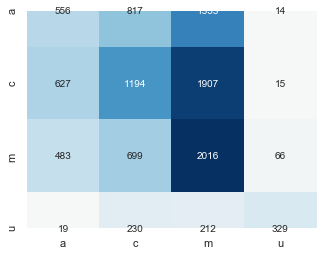

In [20]:
labels_ = ['a', 'c', 'm', 'u']
cmat = confusion_matrix(df_train['groundtruth'][~pd.isnull(df_train['predicted_class'])],
                        df_train['predicted_class'][~pd.isnull(df_train['predicted_class'])],
                        labels=labels_)
df_cmat = pd.DataFrame(cmat.T, labels_, labels_)
sn.set(font_scale=1)  # for label size
sn.heatmap(df_cmat, annot=True, annot_kws={"size": 10}, fmt='d', cbar=False,
           cmap='RdBu', center=0, square=True)  # font size

plt.show()

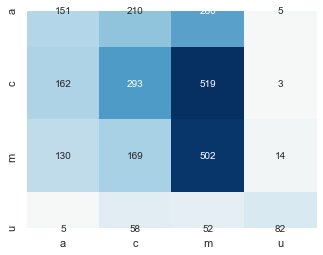

In [21]:
cmat = confusion_matrix(df_val['groundtruth'][~pd.isnull(df_val['predicted_class'])],
                        df_val['predicted_class'][~pd.isnull(df_val['predicted_class'])],
                        labels=labels_)
df_cmat = pd.DataFrame(cmat.T, labels_, labels_)
sn.set(font_scale=1)  # for label size
sn.heatmap(df_cmat, annot=True, annot_kws={"size": 10}, fmt='d', cbar=False,
           cmap='RdBu', center=0, square=True)  # font size

plt.show()

In [22]:
df_train.groupby('groundtruth')['text'].count()

df_train.groupby('predicted_class')['text'].count()

predicted_class
a    2740
c    3743
m    3264
u    790 
Name: text, dtype: int64

In [23]:
import sklearn.metrics as sklm

print(sklm.classification_report(y_true=df_val['groundtruth'][~pd.isnull(df_val['predicted_class'])],
                        y_pred = df_val['predicted_class'][~pd.isnull(df_val['predicted_class'])],
                        labels=labels_))

              precision    recall  f1-score   support

           a       0.23      0.34      0.28       448
           c       0.30      0.40      0.34       730
           m       0.62      0.37      0.46      1353
           u       0.42      0.79      0.54       104

    accuracy                           0.39      2635
   macro avg       0.39      0.47      0.41      2635
weighted avg       0.46      0.39      0.40      2635



In [24]:
drugs = {
    'acetaminophen',
    'hydrocodone',
    'codeine',
    'chlorpheniramine',
    'morphine',
    'buprenorphine',
    'hydromorphone',
    'butorphanol',
    'ipratropium',
    'fentanyl',
    'oxycodone',
    'methadone',
    'tramadol',
    'aspirin',
    'guaifenesin',
    'caffeine',
    'nalbuphine',
    'homatropine',
    'remifentanil',
    'sufentanil',
    'naloxone',
    'meperidine',
    'dihydrocodeine',
    'oxymorphone',
    'ibuprofen',
    'phenylephrine',
    'brompheniramine',
    'pseudoephedrine',
    'pentazocine',
    'butalbital',
    'carisoprodol',
    'promethazine',
    'levorphanol',
    'vicodin',
    'anexsia',
    'lorcet',
    'taxadone',
    'reprexain',
    'dolacet',
    'xylon',
    'cocet',
    'tussicaps',
    'kadian',
    'subutex',
    'dilaudid',
    'torbugesic',
    'atrovent',
    'xodol',
    'duragesic',
    'norco',
    'percocet',
    'endocet',
    'lynox',
    'oramorph',
    'dolophine',
    'dazidox',
    'physeptone',
    'ultram',
    'roxanol',
    'duocet',
    'oxynorm',
    'actiq',
    'lortab',
    'nubain',
    'ryzolt',
    'perloxx',
    'morphabond',
    'zydol',
    'sevredol',
    'roxicodone',
    'hydrotropine',
    'hydromide',
    'astramorph',
    'ultiva',
    'sufenta',
    'ionsys',
    'tramake',
    'oxycontin',
    'percodan',
    'tylenol',
    'suboxone',
    'zamadol',
    'trezix',
    'verdrocet',
    'oncet',
    'glydeine',
    'procet',
    'demerol',
    'roxicet',
    'stadol',
    'roxilox',
    'endodan',
    'maxidone',
    'zerlor',
    'synalgos-dc',
    'combunox',
    'panlor',
    'butorphic',
    'tuzistra',
    'methadose',
    'tylagesic',
    'zomorph',
    'opana',
    'depodur',
    'ibudone',
    'pethilorfan',
    'vanacet',
    'hyco-pap',
    'aceon',
    'hycodan',
    'hydrogesic',
    'primlev',
    'zydone',
    'co-gesic',
    'phenco-care',
    'tussionex',
    'sublimaze',
    'msir',
    'm-eslon',
    'hydropane',
    'magnacet',
    'onsolis',
    'vendone',
    'eth-oxydose',
    'hydromet',
    'm-oxy',
    'pyregesic',
    'oxecta',
    'm-phen',
    'vidone',
    'margesic-h',
    'codrix',
    'hy-phen',
    'tussigon',
    'zamicet',
    'ascomp',
    'rms',
    'oxyrapid',
    'duramorph',
    'hycomed',
    'endocodone',
    'guai-co',
    'conzip',
    'ugesic',
    'rybix',
    'stagesic',
    'zolvit',
    'brontex',
    'codafen',
    'oxydose',
    'vicoprofen',
    'ultracet',
    'panacet',
    'hycet',
    'zyfrel',
    'methex',
    'hydrostat',
    'duoneb',
    't-gesic',
    'cheratussin',
    'tramalgin',
    'percolone',
    'polygesic',
    'allay',
    'oxyfast',
    'buprenex',
    'dolagesic',
    'tylox',
    'oxaydo',
    'hydrocet',
    'talacen',
    'l-dromoran',
    'fentora',
    'alprazolam',
    'chlordiazepoxide',
    'clonazepam',
    'diazepam',
    'estazolam',
    'flurazepam',
    'lorazepam',
    'oxazepam',
    'temazepam',
    'triazolam',
    'clobazam',
    'clorazepate',
    'quazepam',
    'calprazolam',
    'niravam',
    'xanax',
    'chlordinium',
    'clindex',
    'h-tran',
    'librax',
    'libritabs',
    'librium',
    'limbitrol',
    'mitran',
    'poxi',
    'tropium',
    'ceberclon',
    'klonopin',
    'rivotril',
    'valpax',
    'alupram',
    'atensine',
    'd-val',
    'dialar',
    'diastat',
    'diazemuls',
    'dizac',
    'evacalm',
    'rimapam',
    'stesolid',
    'tensium',
    'valicot',
    'valium',
    'zetran',
    'prosom',
    'dalmane',
    'almazine',
    'ativan',
    'serax',
    'restoril',
    'halcion',
    'frisium',
    'onfi',
    'gen-xene',
    'tranxene',
    'doral',
    'asenapine',
    'clozapine',
    'risperidone',
    'aripiprazole',
    'brexpiprazole',
    'cariprazine',
    'iloperidone',
    'lurasidone',
    'olanzapine',
    'paliperidone',
    'pimavanserin',
    'quetiapine',
    'ziprasidone',
    'saphris',
    'clozaril',
    'fazaclo',
    'versacloz',
    'risperdal',
    'abilify',
    'aristada',
    'rexulti',
    'vraylar',
    'fanapt',
    'latuda',
    'symbyax',
    'zyprexa',
    'invega',
    'nuplazid',
    'seroquel',
    'geodon',
    'amphetamine',
    'dextroamphetamine',
    'doxapram',
    'lisdexamfetamine',
    'methamphetamine',
    'methylphenidate',
    'tropicamide',
    'armodafinil',
    'dexmethylphenidate',
    'modafinil',
    'p-hydroxyamphetamine',
    'adderall',
    'adderall-xr',
    'evekeo',
    'mydayis',
    'dexedrine',
    'dextrostat',
    'durophet',
    'liquadd',
    'procentra',
    'zenzedi',
    'dopram',
    'respiram',
    'vyvanse',
    'desoxyn',
    'aptensio',
    'concerta',
    'metadate',
    'methylin',
    'quillivant',
    'ritalin',
    'ritalin-sr',
    'paremyd',
    'nuvigil',
    'focalin',
    'aller-tec',
    'provigil',
    }

drug_rex = "(" + '|'.format(drugs) + ")"
df_train['text'] = df_train['text'].map(str)

df_drugs = df_train[df_train.text.map(lambda x: re.search(drug_rex, x.lower()) is not None)]
df_drugs.sample(7)

,text,label,groundtruth,predicted_class,correct?
2196,_U _U _U yeah & i have xanax &painkillers to help me lol my ankle is still f'ed..wore tennis shoes & brace,2,c,c,True
34,pop an adderall i'm sweatin woooo😎,0,c,a,False
1799,"Pretty pissed that I was on morphine and tramadol for weeks when I was sick and I never tripped, not once",0,c,a,False
3682,_U that's what i say every time i don't take my adderall,2,c,c,True
8049,_U xanax is garbage.,2,m,c,False
1658,the amount of seroquel i'm on could probably tranquilize a horse,1,c,m,False
4101,_U in between shots i take lyrica and bacfolan,3,c,u,False


In [ ]:
df_drugs['text'][:20]

In [ ]:
for d in drugs:
    df_drugs[d] = df_train.text.map(lambda x: 1 if d in x.lower() else 0)
    
df_drugs.sample(3)

In [ ]:
df_drug_mentions = df_drugs.drop(columns=['text', 'label', 'groundtruth', 'predicted_class', 'correct?'])

df_drug_mentions_sum = df_drug_mentions.sum().sort_values(ascending=False)

df_drug_mentions_sum[df_drug_mentions_sum > 5]

In [ ]:
! pip install ekphrasis
! pip install jsonlines

In [ ]:
df_train.head()

In [ ]:


from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that waill be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
 #   annotate={},
     annotate={"hashtag", "allcaps", "elongated", "repeated",
         'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

sentences = df_train['text'].tolist()[:11]

for s in sentences:
    print(type(s), s)
    print(" ".join(text_processor.pre_process_doc(s)))

In [ ]:
def replace_U(text):
    return text.replace("_U", "<user>")


def preprocess_tweet_text(s):
    s = replace_U(s)
    
    return " ".join(text_processor.pre_process_doc(s))


In [ ]:
    
def write_df(df, out_path, text_col='text', label_col='class', metadata=None):
    """
    takes a datafrmae, writes out text col, label col
    """
    
    cnt = 0
    with jsonlines.open(out_path, 'w') as writer:
        for i, row in df.iterrows():
            if metadata is None:
                metadata_res = ''
            metadata_res = row[metadata]
            #tweetid = row['tweetid']
            text = row[text_col]
            text = preprocess_tweet_text(text)
            label = row[label_col]
            # to strip white spaces and etc
            label = label.strip()
            writer.write({
                'text': text,
                'label': label,
                'metadata': metadata,

            })
            
            
            cnt += 1
    print(f"wrote {cnt} lines to {out_path}")
    


    

In [ ]:
write_df(df_raw, out_path='train.jsonl', text_col='unprocessed_text', label_col='class', metadata='tweetid')
df_raw.head()

In [ ]:
write_df(df_val_raw, out_path='validation.jsonl', text_col='unprocessed_text', label_col='class', metadata='tweetid')


In [ ]:
df_val_raw.head()

In [ ]:
df_val_raw

In [ ]:
def replace_U(text):
    return text.replace("_U", "<user>")

df_raw['text'] = df_raw['unprocessed_text'].map(lambda x: preprocess_tweet_text(replace_U(x)))

In [ ]:
# stripping
df_raw['class'] = df_raw['class'].map(str.strip)


In [ ]:
map_class = {
    'a': 'ABUSE',
    'm': 'MENTION',
    'u': 'UNRELATED',
    'c': 'CONSUMPTION'}
print(df_raw.columns)

In [ ]:
#df_val_raw

In [ ]:
all_new_aug_train_annot = []

reader = df_raw.to_dict('records')
cnt = 0
for obj in reader:
    cnt += 1
    if cnt % 1000 == 0:
        print(f"{cnt} tweets processed")
    text = obj['text']
    text = preprocess_tweet_text(text)
    label = obj['class']

    meta = obj['tweetid']
    label = map_class.get(label)
    #print(f"{text}: {label}")
    all_new_aug_train_annot.append({
        "text": text,
        "label": label,
        "metadata": meta
    })
    
print(len(all_new_aug_train_annot))

In [ ]:

df_val_raw['class'] = df_val_raw['class'].map(str.strip)
#train_aug_ek_fn = 'train_aug_ekphrasis_annotated.jsonl'

r2 = df_val_raw.to_dict('records')


#with jsonlines.open('train_aug_ekphrasis_annotated.jsonl', 'r') as reader:
cnt = 0
for obj in r2:
    cnt += 1
    if cnt % 1000 == 0:
        print(f"{cnt} tweets processed")
    text = obj['text']
    text = preprocess_tweet_text(text)
    label = obj['class']
    label = map_class.get(label)
    metadata = 'augmented'
    all_new_aug_train_annot.append({'text': text,
                                   'label': label,
                                   'metadata': metadata
                                   })
len(all_new_aug_train_annot)

In [ ]:
annot_guidelines = [{'text': '#knowyouranon ive taken zoloft (antidepressants) and vyvanse (adhd meds) for over a year now',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': '@username that may be why it reduces anxiety and depression in some and can help with ptsd symptoms. i use it for pmdd, 40mg prozac',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'i was recommended vyvanse by my doctor to help me focus. i took my first one today and i feel more jittery than focused',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'plus-side of my life, enbrel is working, psoriasis is leaving! maybe my mental state will continue to improve as well. ...lol...',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "i'm on like 80mg of prozac and trazedome and im still crazy and bipolar seeming",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': '@username adderall b like "hey don\'t you have normal life to deal with too late you are organizing your sock drawer for 2hr" #adhdlife',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "i'm on like 80mg of prozac and trazedome and im still crazy and bipolar seeming",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': '@username adderall b like "hey don\'t you have normal life to deal with too late you are organizing your sock drawer for 2hr" #adhdlife',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'prozac made me lose my mind, see things and have increased suicide thoughts. but the government calls it safe.',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'still effexor withdrawal. this is the last time i ever take anti depressants.',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "lamictal is nice because it makes me chill out but it also makes me feel like i'm gonna throw up everywhere",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'vyvanse is the devil. why am i still awake?! why have i only slept for one hour? why is it not out of my system by now? 😳😁👎',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'i must seriously suffer from that sad need more sunshine please! thanks in advance or do i need to order the prozac xx #bleurghh',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'interested in the pain relief aspect of cymbalta but not the horrific withdrawal if i ever go off of it (ssri withdrawal is bad enough).',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'has anyone taken pregabalin for anxiety? my old psych suggested it (before the new ones put me on quetiapine) &amp; thinking of trying to &gt;',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "if you ever need to clean your room, take a vyvanse and then you'll clean your room, your car and the rest of the house. and the yard.",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "there isn't enough vyvanse in the world to get me through a traffic jam without totally losing my shit.",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'adderall has me having 15 minute conversations about piercings with the cashier at publix',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'my doc says vyvanse is supposed to last 12 hours. uhhhhhhh. is that true for any of you? def not true for me',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "actually don't feel ready to come off my fluoxetine anymore, asdfghjkl i just dont know",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'doc increased my add med &amp; prozac dose. hoping for improved focus, ability to stay awake all day. that mixed with workout plan should help!',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'forgot to take my vyvanse this morning so i might as well not even be at school',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'i had to be taken of nuvigil today because of a reaction i was having, doctor will likely try adderall next .. what meds have worked for you',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'got switched to vyvanse and off concerta so probably going to loose like 10 pounds',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'i have a prescription for paxil now. thanks to everybody that was real w/ me about depression stuff',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "@username i have ms too. i have been on tysabri for 4 years, and diagnosed for 11. i'm 26, and doing well, what r u doing for treatment?",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'where is my mother to force my adderall down my throat &amp; make me do 2849392883 hours of calc/accounting....mother?!?!',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "passing a chickfila before 10:30 and not stopping to get breakfast is how you know you're on vyvanse",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'generic xanax and adderall look far too similar. oh no what have i done...?',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': "i swear vyvanse got you finishing things you didn't know you had to doo #justironedmysocks",
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'vyvanse i love you so effin much omg like i want to marry you i want to comfort you i want to make love to you i want to love you baby mmmmm',
  'label': 'c',
  'meta': 'smm4h-guideline'},
 {'text': 'Nothing cleans these clothes like oxy does.. and the smell too!',
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': "@username @username 6 books AND a master's thesis? OK, you are now officially my heroine.",
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': "keyla said she didn't want to sleep with drea , because the dog sinks so , now she's in here with me and lyrica",
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': '(#ig_haiiddy_x13) lyrica anderson ft wiz khalifa – freakin: lyrica anderson ft wiz khalifa – freakin download: lyri...  (#ig_haiiddy_x13)',
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': '“@username: cannot believe what savella just said to me looool” / loool mikro joke orrr? 😂',
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': 'how are people calmly tweetig song lyrica we are 20k bhind  #votekatniss',
  'label': 'u',
  'meta': 'smm4h-guideline'},
 {'text': "when you don't take a vyvanse for more than three weeks and then you do you get high as shit for a little",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'man fuck the person who introduced me to fluoxetine and olanzapine ..who decided it was smart to fuck with crazy people drugs .. #loopy. ^_^',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "maybe that second purple drink and liquid hydrocodone mix was overkill.... i'm seeing ghost shit out the corner of my eyes down the hallway",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "@username @username i'm just taking some more codeine with my diazepam before i leave. i feel epic!",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'you know you took too much adderall when you stalk your own facebook profile back to 2007',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'gonna double up on my prozac tonight and hope to god things can only go up from here.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'when you take too much adderall and it gives you the jitters &lt;&lt;&lt;&lt;&lt;&lt;&lt;&lt;&lt;',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "let's see how fast a double dose of hydrocodone will knock me out #thewaitinggame",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'time for my daily afternoon relaxation ritual of smoking weed, taking 2 mgs of clonazepam, and 400 mg of seroquel xr.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'why just drink a lot or just take a seroquel to get to sleep when you can do both?',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "never forget the 2 most important a's of college: alcohol and adderall 🍻💊",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'adderall and red bull work magic @username and @username #round2',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': '(iv) The tweet expresses a mechanism of intake that is typically associated with abuse/misuse',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'alright so the plan is. snort adderall then count the stars in a star wars movie',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'snorted a line of oxycodone last night &amp; swear i was feeling alllll types of waysss since i was on molly.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': '@username one time i shoved adderall up my ass and since your intestines are super absorbant i got jacked as fuck',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'shot some of that oxy thru ma veins',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'i may not have weed, but i do have 5 seroquel i found while cleaning my room :3  -g',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'i found an adderall in my carpet today and sat at my computer on adobe illustrator for hours and hours just making shit',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'had a dream that i found some adderall to help me stay awake at work and when i woke up i did find some',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'i was really exhausted at work then i found a random 30 adderall in my purse there is a god',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'im bout to slip some of my seroquel into her drink. she gonna be knocked',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'my roommate took one of my vyvanse and has pooped like 4 times.   confirmation: girls poop.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': '@username thanks gail, havin a lil help from my friends oxycodone &amp; cannacap. (i come back friday) ??????',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'literally tho, could someone sell me an adderall or vyvanse? i just got paid',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "anyone want to buy valium or adderall because i have an abundance and don't fuck with either",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'shout out to the guy at savers who sold me vyvanse (shout out to me for buying it) and got me hooked on adhd meds since',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "goin' to the x-games, got a suitcase full of adderall and dexedrine time to make some cash selling it to cod teams #esports #dare",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'and now is when we pray to the adderall gods for solid learning enhancement.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'i have so much to do and not a lot of time to do it. adderall to the rescue, i guess.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'Time for some vyvanse and finish this assignment tonight!',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "fuck working out, i'm done with that shit, it's been a month and i've gained weight. back to vyvanse and copious amounts of iced coffee.",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'if u wna lose weight just do what i did -start smoking cigarettes +get a vyvanse prescription! youll wna die but atleast ur ribs will show:)',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "i took a left over vyvanse i had from finals week so in about an hour if i start tweeting a lot i'm sorry",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'mom: how many xanax pills did you take?  me: good vibes and good times mom chill.',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'chinese an cake jus do wat i say an nobody die i open tha soda i get tha codeine an i poured up a lot',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'i found a random bag of adderall in my room earlier today and then lost it somewhere else in my house ???? #freakingout #cantfindit',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "line of adderall at 11:05? no thanks. i'll stick to my ganja and make fun of you till you fall asleep at 4am. #weedwins #adderallloses",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "i convinced my mom to give me a xanax at 7 for my panic attacks but i just realized i need to save it for the comedown. i'm craving it now",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "here's where my addiction to codeine began. i bought codeine over the counter for the constant pain i had in my left side.",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'could just be lethargy from taking 15 doses of synthroid when i panickly realised i stopped taking it to avoid getting fat',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'hey i know you were fucked at the head at one point so can you help me out- my cousin asking for adderall',
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "@username took double dose vyvanse today by accident. i'm bouncin of da wallz.",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': "@username if this tweet sticks i'll eat my hat (made of adderall )",
  'label': 'a',
  'meta': 'smm4h-guideline'},
 {'text': 'fda recommends paroxetine (paxil) not be prescribed for children. risk of suicide and lack of efficacy  #teenhealth',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'fosamax has been linked to many side effects that include femur fractures, esophagus problems &amp; hardening of the jaw. 1.888.520.5202.',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "ok just saw a commercial for a medicine called humira for crohn's disease but i'm 99% sure a week ago it was for a different disease. not ok",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'ciprofloxacin is active against both gram-positive and gram-negative bacteria. it is particularly active against gram-negative bacteria.....',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "the adderall tweets are not even funny to me. if you saw what i see at work daily it wouldn't be funny to you either. #sosad",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': '@username a clockwork orange is super good if you like dystopias or prozac nation which is really depressing but one of my favorites.',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "@username narly, radical, on the block i'm magical. see me at your college campus, baggie full of adderall 👅",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'adderall to stay focused xanax to take the edge off pot to mellow me out cocaine to wake me back up again and morphine..well b/c its awesome',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': '@username a big improvement after going to seahawks? that adderall may have helped',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'we used to take acid to feel different, nowadays we take prozac to feel normal',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "this substitute teacher must have taken an adderall just to teach the class, she's jittery af",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "anyone else feel like professors should go easier on people who don't have an adderall prescription..,..",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "she tweeting like she's on adderall 😂😂😭@username @username @username #r5mcplaytakeover http://t.co/c31kwfsnug",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "i can't stop laughing about the @username skit about second-term strength paxil - not covered by obamacare.",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'seeing a boatload of duloxetine here the past several days, too. @username',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'gary lewis just mentioned we as students take prozac during finals......whut....',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'morgans dog name is addi and this drunk guy keeps calling her adderall 😭',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'one of my favorite kids is indigo and his mom gives him adderall :( i told her to stop that shit',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'megan has to take an adderall so she can be more chatty and be able to talk to boys lol',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "when finals rolls around i can't tell if people are really social and nice to me because that's just who they are or if they are on adderall",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'if my group member shows up high again tomorrow it better be from adderall and not weed because nobody got time for a stoned group member',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': '“@username: trying to sleep.. but this vyvanse is keeping me up” rmft',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'only @username would ask her dad if she should take an adderall tomorrow 😂😂',
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "85% of a university student's diet at this time of year consists of coffee and adderall #unilife #statscan",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "RT don't pop e, adderall &amp; drink straight liquor in one night then decide to have sex. you will wake up 3 weeks later pregnant. be smart lmao",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': "i always panic before a paper, always... this is the part where i'm supposed to ask my gp for prozac or roofies but nooo, @username",
  'label': 'm',
  'meta': 'smm4h-guideline'},
 {'text': 'so glad i did my research and never let no one to convince me to go on tysabri or gilenya. dr. @username was so informative!',
  'label': 'm',
  'meta': 'smm4h-guideline'}]

In [ ]:
len(all_new_aug_train_annot)

In [ ]:
cnt = 0
for obj in annot_guidelines:
    cnt += 1
    if cnt % 100 == 0:
        print(cnt)
    text = obj['text']
    text = preprocess_tweet_text(text)
    label = obj['label']
    label = map_class.get(label)
    metadata = obj['meta']
    all_new_aug_train_annot.append({'text': text,
                                   'label': label,
                                   'metadata': metadata})
    

In [ ]:
print(len(all_new_aug_train_annot))

In [ ]:
all_dat_add_df = pd.DataFrame(all_new_aug_train_annot)

In [ ]:
all_dat_add_df['metadata'] = all_dat_add_df['metadata'].map(str)
df_ = all_dat_add_df.sort_values(['text','metadata'])


In [ ]:
new_train_mixed_with_aug = df_.sort_values('metadata').drop_duplicates('text').to_dict('records')

In [ ]:
other_dict=[{'text': 'in to help with sleep...', 'label': 'CONSUMPTION', 'metadata': '0'},
 {'text': "maybe i've just been lucky! talking of aps, my nightly dose of quetiapine is kicking in. night all",
  'label': 'CONSUMPTION',
  'metadata': '53c442115378181c5b27936b'},
 {'text': "back to sleep for me!! can't stay awake on this new dose of quetiapine xx",
  'label': 'CONSUMPTION',
  'metadata': '53c4cfb95378994ef7549394'},
 {'text': 'new launch item! sky now offers quetiapine fumarate 100ct tablets in 100mg, 200mg, and 300mg strengths. place your order now!',
  'label': 'ABUSE',
  'metadata': '53c549595378181c5b279427'},
 {'text': "good evening! :-d thanks, i'm still waking up one-two times a night. someone told me quetiapine puts you to sleep but doesn't",
  'label': 'CONSUMPTION',
  'metadata': '53c617455378181c5b2794cb'},
 {'text': 'see if you can get something for the anxiety, do you take any extra quetiapine prn?',
  'label': 'CONSUMPTION',
  'metadata': '53c93e215378181c5b27970b'},
 {'text': 'wtf! since the increase in quetiapine i keep having days where i sleep for almost 24 hours. today was one of those days. gggggrrrrrrrrr',
  'label': 'CONSUMPTION',
  'metadata': '53c9407a5378181c5b27970d'},
 {'text': ':) a lower dose of quetiapine made all the difference to my functionality, though i need to monitor myself carefully',
  'label': 'CONSUMPTION',
  'metadata': '53cd1ad35378994ef754995e'},
 {'text': 'antidepressants + tramadol + quetiapine + alcohol does not = pot+alcohol. not even close',
  'label': 'ABUSE',
  'metadata': '53d0c4bb5378181c5b279c61'},
 {'text': "that's how i felt when the quetiapine started to work. extreme calm.",
  'label': 'CONSUMPTION',
  'metadata': '53d12b855378181c5b279ca4'},
 {'text': "it wasn't good, i collapsed in b&amp;q. luckily quetiapine seems to have been ok for me. it seems to work with my depakote.",
  'label': 'CONSUMPTION',
  'metadata': '53d80b0e5378181c5b27a25a'},
 {'text': "its the quetiapine for me as well. luckily it is a lot easier now that i'm down to 150mg. the depakote isn't ideal either though.",
  'label': 'CONSUMPTION',
  'metadata': '53daaedb5378181c5b27a4a8'},
 {'text': 'my psych suggested adding quetiapine',
  'label': 'CONSUMPTION',
  'metadata': '53ddddd7537820109a2a140'},
 {'text': 'up to 100mg of quetiapine now. really feeling it. quite prepared to just curl up and nap on the floor.',
  'label': 'CONSUMPTION',
  'metadata': '53de4cca5378181c5b27a798'},
 {'text': 'sedative effect from quetiapine allowing the brain to shut down and aid against insomnia. #happypills',
  'label': 'CONSUMPTION',
  'metadata': '53debec05378181c5b27a7fc'},
 {'text': "with that concoction i'm sure you'll sleep like a baby! my quetiapine alone makes me very drowsy!",
  'label': 'CONSUMPTION',
  'metadata': '53dfc4d05378181c5b27a8b9'},
 {'text': 'but could easily be precipitated by a general sedative, such as a high dose of quetiapine or even doxylamine succinate',
  'label': 'CONSUMPTION',
  'metadata': '53e53e855378181c5b27adb3'},
 {'text': "i'm on citalopram, propranolol, quetiapine and respiridone, but think i'll stop the anti-psychs.",
  'label': 'CONSUMPTION',
  'metadata': '53e7a9d45378181c5b27af68'},
 {'text': "it's been three years now, as i come slowly off the quetiapine i realise it's been masking the thirst and the full bladder&gt;",
  'label': 'CONSUMPTION',
  'metadata': '53e9197f5378181c5b27b08d'},
 {'text': 'no! the risperidone - aripiprazole - quetiapine - clozapine wore off.',
  'label': 'CONSUMPTION',
  'metadata': '53e9322e5378181c5b27b0a5'},
 {'text': "freedom pass. see my last rt from them. i've had mine since i started quetiapine - prohibited from driving.",
  'label': 'CONSUMPTION',
  'metadata': '53ec90d15378181c5b27b392'},
 {'text': "got my meds changed today. from now on i'm taking trazadone &amp; quetiapine in the evening and bupropion in the morning.",
  'label': 'CONSUMPTION',
  'metadata': '53ed35165378181c5b27b41f'},
 {'text': 'fuck this is intense but the quetiapine has kicked in&amp; staying awake is a struggle now #ausvnzl',
  'label': 'CONSUMPTION',
  'metadata': '53ef447c5378181c5b27b5a6'},
 {'text': "this is horribly familiar, but i'd hoped not to feel it for a while: low mood mixed with extreme quetiapine sedation. an awful cocktail.",
  'label': 'CONSUMPTION',
  'metadata': '53efb8a35378181c5b27b5e7'},
 {'text': 'also tired! quetiapine makes me want to sleep forever...',
  'label': 'CONSUMPTION',
  'metadata': '53f5a9a05378181c5b27ba1c'},
 {'text': 'the only bad thing about quetiapine for sleep is that i wake up stupidly early on sleep-in days',
  'label': 'CONSUMPTION',
  'metadata': '53f796305378181c5b27bbb5'},
 {'text': 'digging out my old sega, going to play splatterhouse, drunk on beer and high on [free] quetiapine',
  'label': 'ABUSE',
  'metadata': '53f971b25378181c5b27bd08'},
 {'text': "i'm 99.9% sure i took my meds tonight but i've not got the foggy tiredness i usually get from quetiapine yet, which i'd usually have by now.",
  'label': 'CONSUMPTION',
  'metadata': '53fa5b865378181c5b27bdc6'},
 {'text': 'so hungry. all this extra prn quetiapine is having that affect on me :-(',
  'label': 'CONSUMPTION',
  'metadata': '53fb5dda5378181c5b27be7b'},
 {'text': 'i hav bn on quetiapine since 2006 &amp; havnt put on weight. but it is a side-effect, not as much as some aps',
  'label': 'CONSUMPTION',
  'metadata': '53fe576e5378181c5b27c0b7'},
 {'text': "so grateful my gp doesn't put the *real* reason for me needing quetiapine on my prescription. instead, he puts 'for nerves'.",
  'label': 'CONSUMPTION',
  'metadata': '53ff4b9d5378181c5b27c169'},
 {'text': "really did not think halving my quetiapine dose would affect me this much. it's pretty hellish. #mh",
  'label': 'CONSUMPTION',
  'metadata': '540229375378181c5b27c343'},
 {'text': "i'd want to play a game saw styl w/ people i hate by shoving 75 300mg's of quetiapine down their throat &amp; be 'how's being served ur own med?",
  'label': 'CONSUMPTION',
  'metadata': '5403ff5c5378181c5b27c4a4'},
 {'text': "i'm on 600mg quetiapine xl. been taking it since june. my favourite antipsychotic out of the nine i've taken.",
  'label': 'CONSUMPTION',
  'metadata': '54060c485378181c5b27c668'},
 {'text': 'quetiapine has increased mine from 4.8 to 7.1 this year. these atypical antipsychotics can be brutal. :(',
  'label': 'CONSUMPTION',
  'metadata': '5408b4bd5378181c5b27c83c'},
 {'text': 'ive done it once never again. waiting to see a doctor i didnt know and effectively beg for a script for quetiapine and',
  'label': 'CONSUMPTION',
  'metadata': '540a37485378181c5b27c93f'},
 {'text': "i don't have any. normally my seroquel makes me sleep, but i forgot it at home",
  'label': 'CONSUMPTION',
  'metadata': '540ab34c5378181c5b27c98b'},
 {'text': "overdosing on seroquel and xanax cause i can't deal with the pain anymore... hope you get hit by a mack truck, you stupid heartless asshole.",
  'label': 'ABUSE',
  'metadata': '540b8cba5378181c5b27ca1b'},
 {'text': 'got my dose for tonight &gt;&gt;&gt; this seroquel bout to have me rocking !!!',
  'label': 'ABUSE',
  'metadata': '540bd3a75378181c5b27ca50'},
 {'text': "i take seroquel and it makes you hungry as fuck. i've gained 15lbs on it.",
  'label': 'CONSUMPTION',
  'metadata': '540be1db5378181c5b27ca58'},
 {'text': "same. the quetiapine doesn't help in that respect either. i'm basically a zombie until 10:30ish am.",
  'label': 'CONSUMPTION',
  'metadata': '540c8fc35378181c5b27cac1'},
 {'text': 'a heavy former addict in jail was impressed with it. the doc swears by seroquel though. expensive here!',
  'label': 'CONSUMPTION',
  'metadata': '540d17585378181c5b27cb44'},
 {'text': 'without insurance, how much would this cost: venlafaxine x 28 co-codamol x 200, valium x 28 zopiclone x 14 propranolol x 28, quetiapine x 14',
  'label': 'CONSUMPTION',
  'metadata': '540dbe585378181c5b27cba3'},
 {'text': 'i really miss being able to drink lilt. quetiapine you suck',
  'label': 'CONSUMPTION',
  'metadata': '540dd9f65378181c5b27cbb8'},
 {'text': 'so sad that i am taking seroquel at 8 pm because why tf stay awake',
  'label': 'CONSUMPTION',
  'metadata': '540e6b535378181c5b27cc36'},
 {'text': 'as soon as i lay in bed im passing out fuck u seroquel',
  'label': 'CONSUMPTION',
  'metadata': '540e6c275378181c5b27cc39'},
 {'text': 'seen the pdoc and have valium the benzo equiv of lsd. al insomnia is close to history. seroquel will end all unrest.',
  'label': 'CONSUMPTION',
  'metadata': '540ee3cb5378181c5b27cc75'},
 {'text': 'oh ok.i kp on this quetiapine might b needing to b included it that bracket then!',
  'label': 'CONSUMPTION',
  'metadata': '540f24495378181c5b27cc9e'},
 {'text': 'my seroquel xr costs 74.74... with insurance.. fuck that',
  'label': 'CONSUMPTION',
  'metadata': '540f5fed5378181c5b27cd03'},
 {'text': "i'll just send you both some seroquel in the mail lol. best.sedative.ever.",
  'label': 'ABUSE',
  'metadata': '540fbfe95378181c5b27cd7c'},
 {'text': 'so glad my quetiapine appetite has calmed down. couldnt carry on eating like a heffer. my dinner is just some half burnt parsnips #treatme',
  'label': 'CONSUMPTION',
  'metadata': '5410b5855378181c5b27ce62'},
 {'text': 'i always fall asleep while texting people &amp; they get so mad. like ambien &amp; seroquel knock me the fuck out',
  'label': 'CONSUMPTION',
  'metadata': '5410cd535378181c5b27ce7a'},
 {'text': 'sat with enough quetiapine to send me into a semi-coma.',
  'label': 'MENTION',
  'metadata': '5410d1d95378181c5b27ce7c'},
 {'text': "also - and i hate to do this - i'm going to increase my quetiapine tonight :( no sense taking risks out of insistence on the dose drop :(",
  'label': 'CONSUMPTION',
  'metadata': '5414920a5378181c5b27d147'},
 {'text': "word to the wise. don't take seroquel at/after midnight. you'll be tired and strung out all day.",
  'label': 'CONSUMPTION',
  'metadata': '5415e3e55378181c5b27d262'},
 {'text': 'anyway, hoping some extra quetiapine will at least close the door on that parallel world for now. doubt it will ever go away though.',
  'label': 'CONSUMPTION',
  'metadata': '541618685378181c5b27d2a7'},
 {'text': 'knocking myself out with kpin and seroquel tonight and hoping all the bad feelings will be gone in the morning',
  'label': 'CONSUMPTION',
  'metadata': '5417c02d5378181c5b27d3d4'},
 {'text': 'some sketchy dude on the bus is handing out pills to all the other sketchy dudes in the back of the bus. what up seroquel',
  'label': 'ABUSE',
  'metadata': '5417f88e5378181c5b27d3f1'},
 {'text': "while making calls she might want to call doc 4 scripts 4truthserum bottle o' selfesteem seroquel n std meds #truth #nuts",
  'label': 'CONSUMPTION',
  'metadata': '541933455378181c5b27d4be'},
 {'text': 'taking double my dose of quetiapine so this day will be over',
  'label': 'ABUSE',
  'metadata': '5419e3525378181c5b27d527'},
 {'text': 'my doctor says quetiapine causes weight gain and i had blood taken on wednesday to check my thyroid. they can fix that, right?',
  'label': 'CONSUMPTION',
  'metadata': '541c2fce5378181c5b27d6f5'},
 {'text': 'good :) quetiapine works really really well for some people, but the sleepies for the first few weeks are fairly extreme.',
  'label': 'CONSUMPTION',
  'metadata': '541c87ad5378181c5b27d73a'},
 {'text': "so hungry. it's cruelty to make people on quetiapine wait till the afternoon for surgery. guess i'll come round begging for food as usual.",
  'label': 'CONSUMPTION',
  'metadata': '5422944b5378181c5b27db21'},
 {'text': "and i'd love to see you spend a year+ on quetiapine &amp; see if your opinion changes.",
  'label': 'CONSUMPTION',
  'metadata': '5423fa5a5378181c5b27dc49'},
 {'text': "but don't forget everyone reacts differently to drugs. eg 800mg quetiapine wd keep knocked out permanently yet",
  'label': 'CONSUMPTION',
  'metadata': '542427dc5378181c5b27dc63'}]

In [ ]:
for obj in other_dict:
    text = obj['text']
    text = preprocess_tweet_text(text)
    label = obj['label']
    print(label)
    metadata = obj['metadata']
    all_new_aug_train_annot.append({'text': text,
                                   'label': label,
                                   'metadata': metadata})

In [ ]:
dfallll = pd.DataFrame(all_new_aug_train_annot) #.drop_duplicates('text').sort_values('metadata')

In [ ]:
dfallll.metadata = dfallll.metadata.map(str)

In [ ]:
df1 = dfallll.sort_values(['text', 'metadata']).drop_duplicates('text')

In [ ]:
df1.label.value_counts()

In [ ]:
df1[df1.metadata=='542427dc5378181c5b27dc63']

In [ ]:
from sklearn.utils import shuffle

df1.head()

In [ ]:
shuffle(df1)
df1.head()

In [ ]:

import numpy as np
df_shuffled = df1.reindex(np.random.permutation(df1.index))
df_shuffled

In [ ]:
reder = df_shuffled.to_dict('records')
reder[:4]

In [ ]:
import jsonlines
with jsonlines.open('aug-supp-orig-train.jsonl', 'w') as writer:
    writer.write_all(reder)
        
    